Mount Your Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Install rpy2 version (3.5.1)

In [ ]:
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Library BiocManager

In [ ]:
%R library('BiocManager' , lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")

Install Required Packages

In [ ]:
%%R
#install.packages('' , lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
BiocManager::install('EnhancedVolcano' , lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")

Library necessary packages

In [84]:
%%R
library(Formula , lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(zoo , lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(xts , lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(permute , lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(magrittr ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(ggrepel ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(tidyverse ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(limma ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(vegan ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(cluster ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(factoextra ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(gridExtra ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(PerformanceAnalytics ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(corrplot ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(Hmisc ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(RColorBrewer ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(impute ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(pathview ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(ggplot2 ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(glmnet ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(ggfortify ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(ggpubr ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")
library(EnhancedVolcano ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")

In [85]:
%R library(EnhancedVolcano ,  lib = "/content/gdrive/MyDrive/Colab Notebooks/r_lib")

'Enhanced...,'ggpubr','ggfortify',...,'datasets','methods','base'


In [8]:
%%R
setwd('/content/gdrive/MyDrive/Colab Notebooks/Metabolomics')
getwd()
list.files()

[1] "metabolomics_data.csv"          "metabolomics_meta.csv"         
[3] "Metabolomics_Pipeline_FA.ipynb" "Normalized_data.csv"           
[5] "samples_meta.csv"              


# Load Data

In [9]:
%%R
data=read.csv('metabolomics_data.csv',row.names=1,stringsAsFactors = F,na.strings=c("NA","NaN", ""),check.names=F)
paste('Data Contain' , dim(data)[1], 'samples as rows & ' , dim(data)[2] , 'metabolites as columns')

[1] "Data Contain 131 samples as rows &  841 metabolites as columns"


# Data Cleaning

Convert Data Into Numeric

In [10]:
%%R
int.mat <- data
rowNms <- rownames(int.mat)
colNms <- colnames(int.mat)
num.mat <- apply(int.mat, 2, function(x) as.numeric(gsub(",","", x)))
rownames(num.mat) <- rowNms
colnames(num.mat) <- colNms
print(dim(int.mat))
print(rownames(int.mat)[1:5] )
print(colnames(int.mat)[1:5] )

[1] 131 841
[1] "sample1" "sample2" "sample3" "sample4" "sample5"
[1] "(12 or 13)-methylmyristate (a15:0 or i15:0)"
[2] "(14 or 15)-methylpalmitate (a17:0 or i17:0)"
[3] "(16 or 17)-methylstearate (a19:0 or i19:0)" 
[4] "(2 or 3)-decenoate (10:1n7 or n8)"          
[5] "(2,4 or 2,5)-dimethylphenol sulfate"        


# Data Filteration

Remove Low Variated Metabolites

In [11]:
%%R
variance = 0
varCol=apply(num.mat, 2, var, na.rm = T)
constCol <- (varCol <= variance | is.na(varCol))
num.mat <- num.mat[, !constCol]
print(dim(num.mat))
paste((dim(int.mat)[2] - dim(num.mat)[2]) , 'Metaboiltes Excluded due to variance <= ' , variance)

[1] 131 810
[1] "31 Metaboiltes Excluded due to variance <=  0"


Draw A Histogram of Variance of metabolites across samples

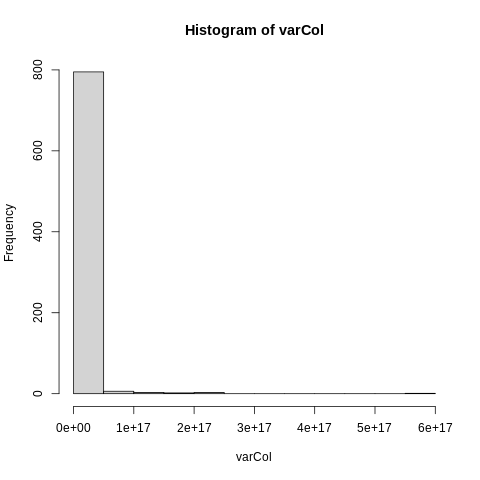

In [12]:
%%R
hist(varCol)

# Compute Missingness Rate per metabolite

Draw A histogram for missing rate of metabolites

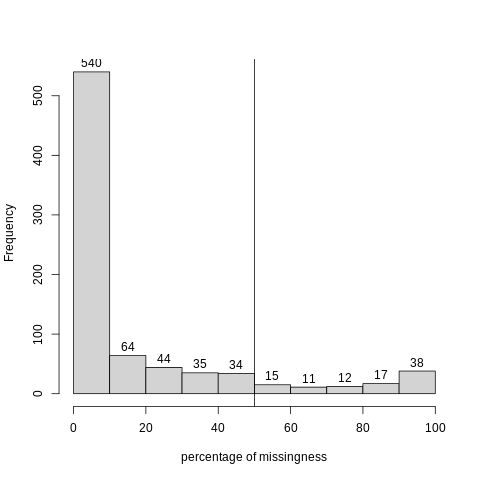

In [13]:
%%R
mR = 50 #missing rate cutoff
h=hist((apply(is.na(num.mat), 2, sum)/nrow(num.mat) ) *100,breaks=10,
main="",
xlab="percentage of missingness")
text(h$mids,h$counts,labels=h$counts, adj=c(0.5, -0.5))
abline(v = mR)

Density Plot

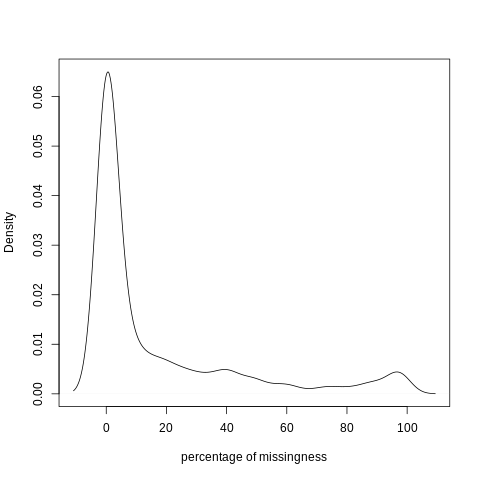

In [14]:
%R plot(density( (apply(is.na(num.mat), 2, sum)/nrow(num.mat) )*100),xlab="percentage of missingness",main='')

Exclude Metabolites with missing ratio more than Cutoff

In [15]:
%%R
good.inx=apply(is.na(num.mat), 2, sum)/nrow(num.mat) <(mR/100)
num.mat=num.mat[,good.inx]
dim(num.mat)

[1] 131 717


# Impute Missing Values

In [16]:
%%R
num.mat.imputed=impute.knn(num.mat)$data
paste(sum(is.na(num.mat.imputed)) , 'missing values are in our data') 

[1] "0 missing values are in our data"


# Normalization Step

Log2 Transformation

In [17]:
%%R
num.mat.imputed.logged <- log2(num.mat.imputed + 1)

Save Logged Data

In [18]:
%R write.csv(num.mat.imputed.logged,'Normalized_data.csv')

# Check data distrubution after and before data normalization

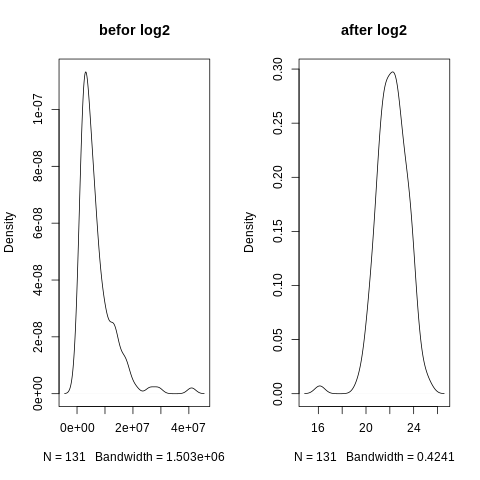

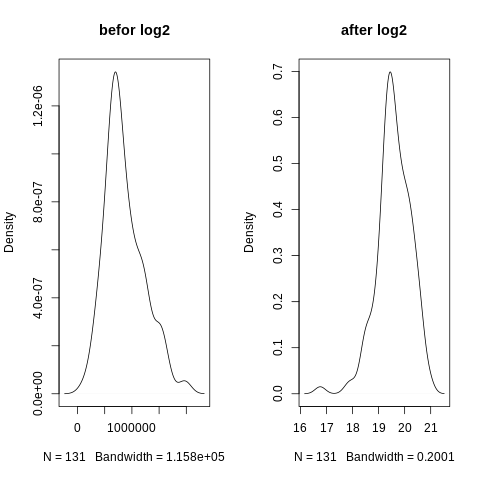

In [19]:
%%R
options(repr.plot.width=15,repr.plot.height=8)

par(mfrow=c(1,2))
plot(density( num.mat.imputed[,156]) ,main='befor log2')
plot(density( num.mat.imputed.logged[,156]), main='after log2' )

par(mfrow=c(1,2))
plot(density( num.mat.imputed[,5]) ,main='befor log2')
plot(density( num.mat.imputed.logged[,5]), main='after log2' )

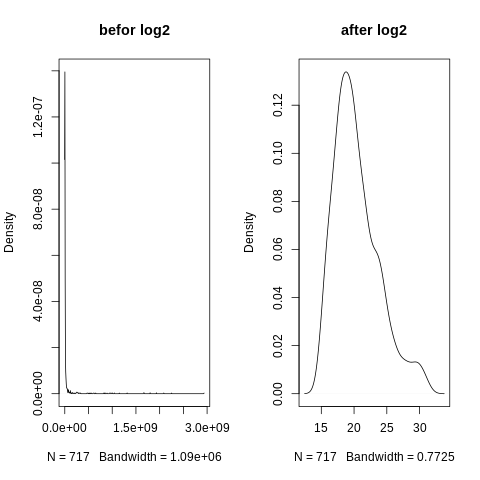

In [20]:
%%R
par(mfrow=c(1,2))
plot(density(apply(num.mat.imputed, 2, mean, na.rm = TRUE)),main='befor log2')
plot(density(apply(num.mat.imputed.logged, 2, mean, na.rm = TRUE)),main='after log2')

Boxplot for 20 metabolites before and after log2 

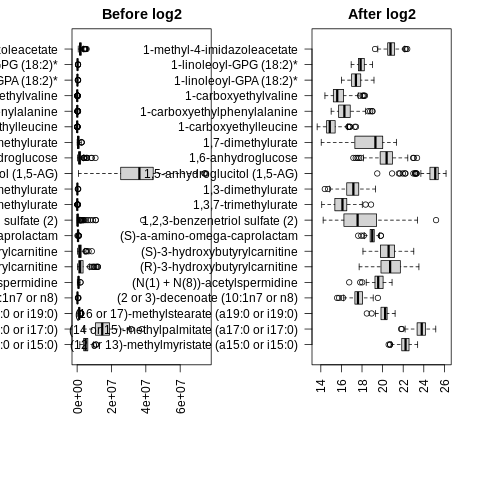

In [21]:
%%R
options(repr.plot.width=10,repr.plot.height=8)
par(mar = c(8,5,2,2),mfrow=c(1,2))
boxplot(num.mat.imputed[,1:20], main="Before log2" ,horizontal=T, names=colnames(num.mat.imputed)[1:20],las=2)
boxplot(num.mat.imputed.logged[,1:20], main="After log2" ,horizontal=T, names=colnames(num.mat.imputed.logged)[1:20],
        las=2)

Boxplot for samples before log2 and after log2

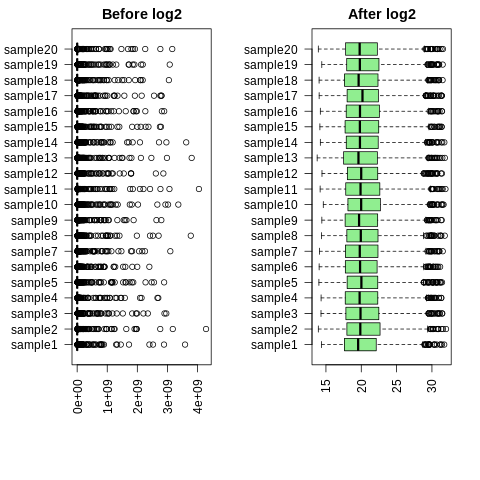

In [22]:
%%R
options(repr.plot.width=10,repr.plot.height=8)
par(mar = c(8,5,2,2),mfrow=c(1,2))
boxplot(t(num.mat.imputed[1:20,]), main="Before log2" ,horizontal=T,las=2,col = "lightgreen")    
boxplot(t(num.mat.imputed.logged[1:20,]), main="After log2" ,horizontal=T,las=2,col = "lightgreen")

Scaling by standerdization

In [23]:
%%R
num.mat.imputed.logged.scaled=scale(num.mat.imputed.logged,center = TRUE, scale = TRUE)

Confirmation of scaling

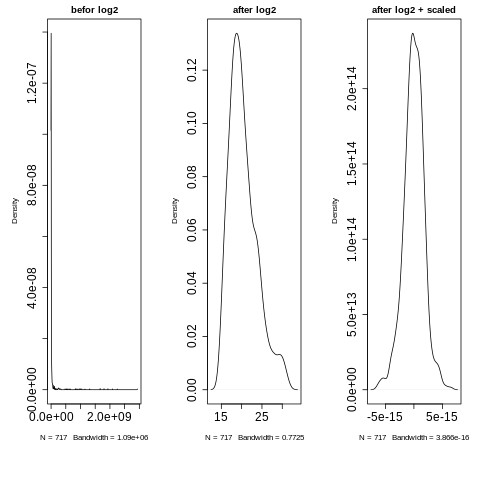

In [24]:
%%R
options(repr.plot.width=20,repr.plot.height=8)

par(mar = c(8,5,2,2),mfrow=c(1,3),cex.axis=1.5)
plot(density(apply(num.mat.imputed, 2, mean, na.rm = TRUE)),main='befor log2')
plot(density(apply(num.mat.imputed.logged, 2, mean, na.rm = TRUE)),main='after log2')
plot(density(apply(num.mat.imputed.logged.scaled, 2, mean, na.rm = TRUE)),main='after log2 + scaled')

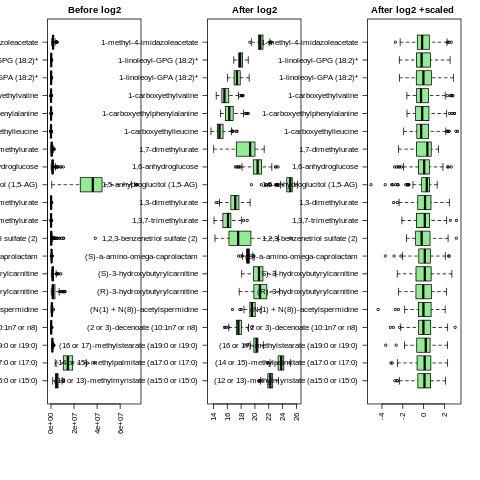

In [25]:
%%R
options(repr.plot.width=10,repr.plot.height=8)
par(mar = c(8,5,2,2),mfrow=c(1,3))
boxplot(num.mat.imputed[,1:20], main="Before log2" ,horizontal=T, names=colnames(num.mat.imputed)[1:20],las=2,
       col = "lightgreen")
boxplot(num.mat.imputed.logged[,1:20], main="After log2" ,horizontal=T, names=colnames(num.mat.imputed.logged)[1:20],
        las=2,col = "lightgreen")
boxplot(num.mat.imputed.logged.scaled[,1:20], main="After log2 +scaled " ,horizontal=T,
        names=colnames(num.mat.imputed.logged.scaled)[1:20],
        las=2,col = "lightgreen")

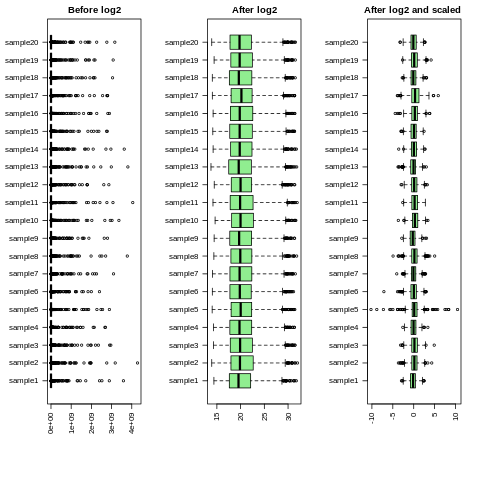

In [26]:
%%R
options(repr.plot.width=10,repr.plot.height=8)
par(mar = c(8,5,2,2),mfrow=c(1,3))
boxplot(t(num.mat.imputed[1:20,]), main="Before log2" ,horizontal=T,las=2,col = "lightgreen")    
boxplot(t(num.mat.imputed.logged[1:20,]), main="After log2" ,horizontal=T,las=2,col = "lightgreen")
boxplot(t(num.mat.imputed.logged.scaled[1:20,]), main="After log2 and scaled " ,horizontal=T,las=2,col = "lightgreen")

# Colinearity Check

Calculate Correlation with imputed data

In [27]:
%%R
descrCor <-  cor(num.mat.imputed)
highCorr <- sum(abs(descrCor[upper.tri(descrCor)]) > .99)
highCorr

[1] 7


Calculate Correlation with logged data

In [28]:
%%R
descrCor <-  cor(num.mat.imputed.logged)
highCorr <- sum(abs(descrCor[upper.tri(descrCor)]) > .99)
summary(descrCor[upper.tri(descrCor)])
highCorr

[1] 0


Calculate Correlation with scaled data

In [29]:
%%R
descrCor <-  cor(num.mat.imputed.logged.scaled)
highCorr <- sum(abs(descrCor[upper.tri(descrCor)]) > .99)
summary(descrCor[upper.tri(descrCor)])
highCorr

[1] 0


Removal Code of highly correlated

In [30]:
%%R 
tmp <- cor(num.mat.imputed)
tmp[upper.tri(tmp)] <- 0
diag(tmp) <- 0
data.new <- num.mat.imputed[, !apply(tmp, 2, function(x) any(abs(x) > 0.99, na.rm = TRUE))]
print(dim(num.mat.imputed))
dim(data.new)

[1] 131 717
[1] 131 713


Plot Correlation Plot between 20 metabolites

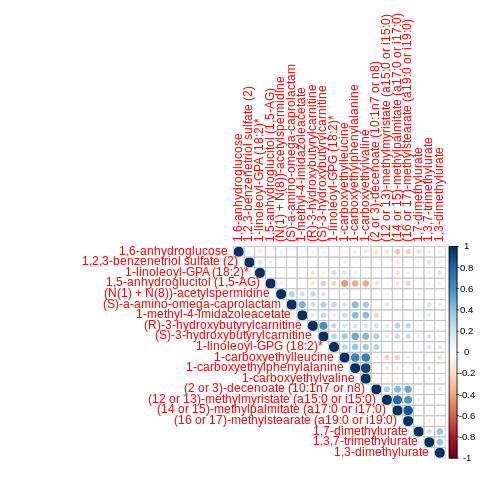

In [31]:
%%R
options(repr.plot.width=10,repr.plot.height=10)
M <-cor(num.mat.imputed.logged[,1:20])
corrplot(M, type="upper", order="hclust" )

Because Cor function does not produce P value of the correlation coefficient, we will use rcorr from Hmisc library

In [32]:
%%R
res2 <- rcorr(as.matrix(num.mat.imputed.logged))
print(res2$P[1:5])
res2$r[1:5]

[1]           NA 0.000000e+00 1.184386e-12 1.129699e-04 3.035289e-01
[1]  1.00000000  0.77123707  0.57008311  0.33094402 -0.09057817


A function to convert the rcorr output into a dataframe

In [33]:
%%R
# convert the correlation matrix into table
flattenCorrMatrix <- function(cormat, pmat) {
  ut <- upper.tri(cormat)
  data.frame(
    row = rownames(cormat)[row(cormat)[ut]],
    column = rownames(cormat)[col(cormat)[ut]],
    cor  =(cormat)[ut],
    p = pmat[ut]
    )
}

Apply the function

In [34]:
%%R
Correlation_matrix_flattened = flattenCorrMatrix(res2$r, res2$P)  

Just to plot the insignificantly correlated metabolites as blank

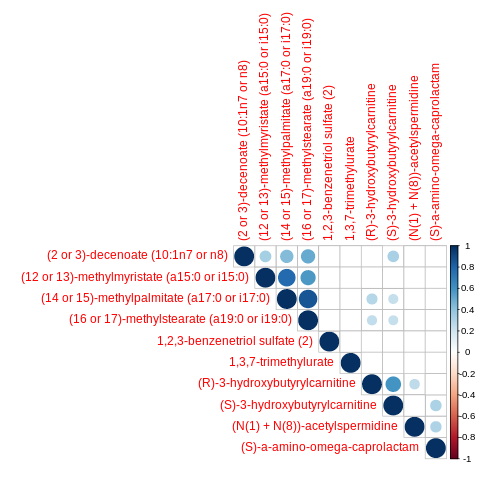

In [36]:
%%R
diag(res2$P[1:10,1:10])=0
corrplot(res2$r[1:10,1:10], type="upper", order="hclust", p.mat = res2$P[1:10,1:10], sig.level = 0.01, insig = "blank")

# Data Reduction

# PCA

In [37]:
%%R
Normalized_data=read.csv('Normalized_data.csv',check.names=F,row.names=1)
dim(Normalized_data)

[1] 131 717


In [38]:
%%R
samples_meta= read.csv("samples_meta.csv",na.strings=c("NA","NaN", ""))       # samples unique ids is the sample id   
head(samples_meta)

  SAMPLE_IDS AGE  BMI GENDER  Group
1    sample1  60 52.7 Female Cancer
2    sample2  48 41.4 Female Cancer
3    sample3  58 43.7 Female Cancer
4    sample4  48 51.3   Male Cancer
5    sample5  53 46.6 Female Cancer
6    sample6  57 42.4 Female Cancer


In [39]:
%%R
options(repr.plot.width=8,repr.plot.height=6)

df_pca <- prcomp(Normalized_data)
df_out <- as.data.frame(df_pca$x)

Features Selection from feature loadings in principal components

In [40]:
%%R
x <- as.data.frame(df_pca$rotation)
print(quantile(x$PC1))
print(quantile(x$PC2))
x1 <- rownames(x %>% select(PC1) %>% filter(PC1 > 0.02) %>% arrange(desc(PC1)))
x2 <- rownames(x %>% select(PC2) %>% filter(PC2 > 0.02) %>% arrange(desc(PC2)))
sum(x1 %in% x2)

          0%          25%          50%          75%         100% 
-0.142067380 -0.012217248  0.006054026  0.023512845  0.109210408 
          0%          25%          50%          75%         100% 
-0.115641500 -0.005482132  0.015166865  0.034459913  0.162461310 
[1] 92


PCA Plot by ggplot2

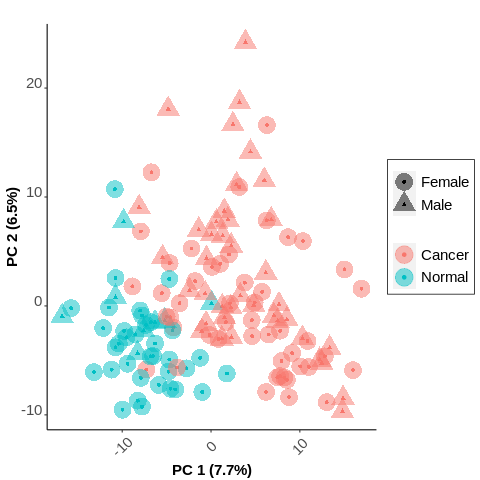

In [41]:
%%R
ggplot(df_out,aes(x=PC1,y=PC2,color=samples_meta$Group,shape=samples_meta$GENDER ))+
geom_point()+ggtitle("")+labs(color='')+
  geom_point(size=8,alpha=0.5)+ #Size and alpha just for fun
theme(  plot.title = element_text(hjust = 0.5,size=15,face = "bold"),
        axis.text.x = element_text( size = 15, angle = 45, hjust = .5, vjust = 0.5, face = "plain"),
        axis.text.y = element_text( size = 15, angle = 0, hjust = 1, vjust = 0, face = "plain"),  
        axis.title.x = element_text( size = 15, angle = 0, hjust = .5, vjust = 0, face = "bold"),
        axis.title.y = element_text( size = 15, angle = 90, hjust = .5, vjust = .5, face = "bold"),
        #legend.title=element_text(size=20),
        legend.title=element_blank(), # remove legend title name
        legend.text = element_text(size=15,face="plain"),
        strip.text = element_text(size = 15,face="plain") ,
        legend.position="right",
        
        # for transparent background
        panel.background = element_rect(fill = "transparent"), # bg of the panel
        plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
        panel.grid.major = element_blank(), # get rid of major grid
        panel.grid.minor = element_blank(), # get rid of minor grid
        legend.background = element_rect(fill = "transparent"), # get rid of legend bg
        legend.box.background = element_rect(fill = "transparent"), # get rid of legend panel bg
        axis.line = element_line(colour = "black") # adding a black line for x and y axis
) +xlab(paste0("PC 1 (", round(df_pca$sdev[1],1),"%)"))+
ylab(paste0("PC 2 (", round(df_pca$sdev[2],1),"%)"))

Plot by autoplot

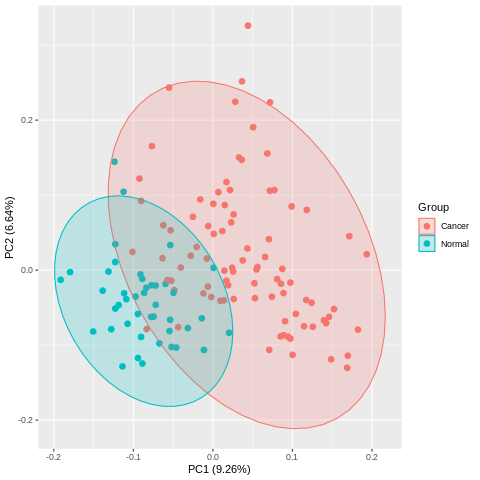

In [42]:
%%R
autoplot(df_pca,
         data = samples_meta,
         colour = 'Group',
         size = 2.5,
         frame = T,
         frame.type = 'norm'
)

# Clustering

# clustering by Kmeans

In [43]:
%%R
kmeans2 <- kmeans((Normalized_data), centers = 2, nstart = 25)

Kmeans Output

In [ ]:
%%R
kmeans2$cluster
kmeans2$centers

Plotting Kmeans Output with fviz_cluster plotting function from factoextra library

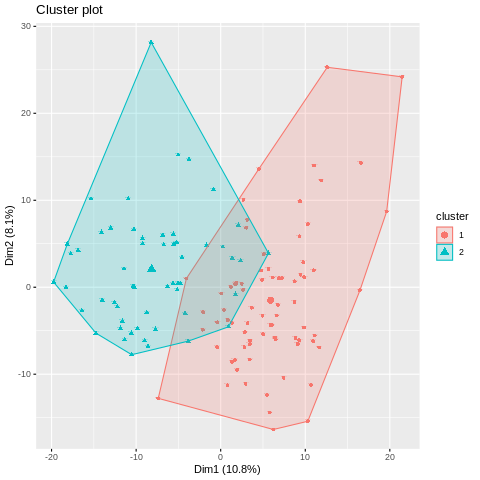

In [45]:
%%R
factoextra::fviz_cluster(kmeans2, data = Normalized_data, ellipse = T,labelsize = 1)

Kmeans with different number of clusters

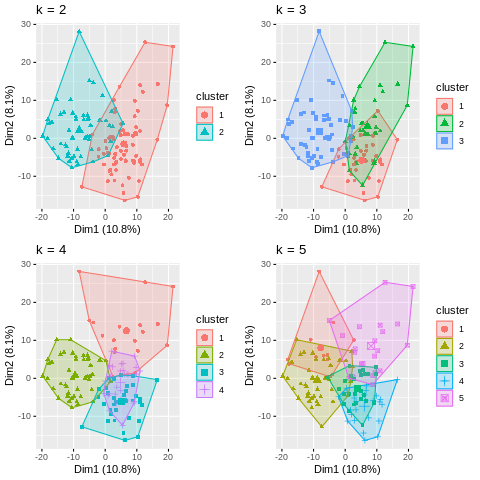

In [46]:
%%R
kmeans3 <- kmeans(Normalized_data, centers = 3, nstart = 25)  #DataFlair
kmeans4 <- kmeans(Normalized_data, centers = 4, nstart = 25)  
kmeans5 <- kmeans(Normalized_data, centers = 5, nstart = 25)  
 #Comparing the Plots
plot1 <- fviz_cluster(kmeans2, geom = "point", data = Normalized_data) + ggtitle("k = 2")
plot2 <- fviz_cluster(kmeans3, geom = "point", data = Normalized_data) + ggtitle("k = 3")
plot3 <- fviz_cluster(kmeans4, geom = "point", data = Normalized_data) + ggtitle("k = 4")
plot4 <- fviz_cluster(kmeans5, geom = "point", data = Normalized_data) + ggtitle("k = 5")
grid.arrange(plot1, plot2, plot3, plot4, nrow = 2)

# Hierarchical Clustering

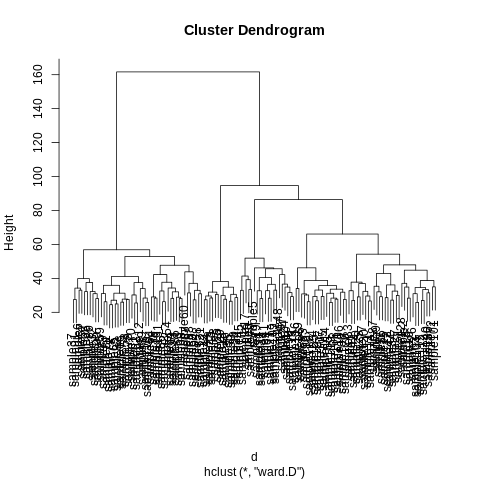

In [49]:
%%R
options(repr.plot.width = 20, repr.plot.height = 6)

# Ward Hierarchical Clustering
d <- dist(Normalized_data, method = "euclidean") # distance matrix
fit <- hclust(d, method="ward")
plot(fit) # display dendogram
groups <- cutree(fit, k=5) # cut tree into 5 clusters

Border Drawing around specific clusters

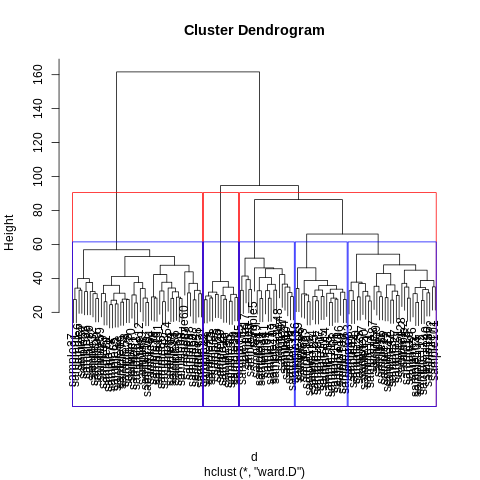

In [50]:
%%R
plot(fit)

# split into 3 clusters

rect.hclust(fit, k=3, border="red")  # split into 13 clusters

rect.hclust(fit, k=5, border="blue")

# Biomarker Discovery

Limma

In [52]:
%%R
type = as.character(samples_meta$Group)

design <- model.matrix(~0+factor(type))
colnames(design) <- levels(factor(type))
contrast<-makeContrasts(Cancer-Normal,levels=design)

fit <- lmFit(as.matrix(t(Normalized_data)), design)
fit2 <- contrasts.fit(fit, contrast)
fit2 <- eBayes(fit2)

In [76]:
%%R
DEGs=topTable(fit2, adjust.method='fdr', number=dim(Normalized_data)[2],p.value=1,coef = 1)
dim(DEGs)
head(DEGs)

                              logFC  AveExpr        t      P.Value    adj.P.Val
mannose                   0.8810866 24.71271 13.55173 9.637590e-27 3.818069e-24
glutamate                 1.1728926 28.83424 13.53418 1.065012e-26 3.818069e-24
gamma-glutamylisoleucine* 0.9138784 19.17334 11.31859 3.631165e-21 8.678485e-19
mannonate*                0.8540031 23.81997 11.18647 7.794701e-21 1.397200e-18
cortolone glucuronide (1) 1.0144815 17.12354 10.75439 9.465297e-20 1.276307e-17
gamma-glutamylleucine     0.6962712 20.25933 10.73348 1.068039e-19 1.276307e-17
                                 B
mannose                   50.21766
glutamate                 50.11919
gamma-glutamylisoleucine* 37.55587
mannonate*                36.80241
cortolone glucuronide (1) 34.33989
gamma-glutamylleucine     34.22078


In [77]:
%%R
meta_meta=read.csv('metabolomics_meta.csv')

In [78]:
%%R
DEGs_filtered <- DEGs  %>%filter(adj.P.Val< 0.05 & abs(logFC) >log2(1)) %>% rownames_to_column('BIOCHEMICAL') %>%
left_join(.,meta_meta %>%select(BIOCHEMICAL,KEGG,HMDB_ID))
names(DEGs_filtered)

Joining, by = "BIOCHEMICAL"
[1] "BIOCHEMICAL" "logFC"       "AveExpr"     "t"           "P.Value"    
[6] "adj.P.Val"   "B"           "KEGG"        "HMDB_ID"    


Filter Total differentially produced metabolites , Up regulated and Down regulated ones 

In [79]:
%%R
res.DEmetabolites <- DEGs_filtered[DEGs_filtered$adj.P.Val< 0.05 & abs(DEGs_filtered$logFC)>log2(1),]
print(paste('total Differentially produced metabolites = ' , dim(res.DEmetabolites)[1]))
res.DEmetabolites.up=DEGs_filtered[DEGs_filtered$adj.P.Val< 0.05 & DEGs_filtered$logFC>log2(1),]
print(paste('UP Differentially produced metabolites = ' , dim(res.DEmetabolites.up)[1]))
res.DEmetabolites.down=DEGs_filtered[DEGs_filtered$adj.P.Val< 0.05 & DEGs_filtered$logFC<(-log2(1)),]
print(paste('DOWN Differentially produced metabolites = ' , dim(res.DEmetabolites.down)[1]))

[1] "total Differentially produced metabolites =  361"
[1] "UP Differentially produced metabolites =  270"
[1] "DOWN Differentially produced metabolites =  91"


Save results as CSV files

In [75]:
%%R
write.csv(res.DEmetabolites , 'res.DEmetabolites.csv')
write.csv(res.DEmetabolites.up , 'res.DEmetabolites.up.csv')
write.csv(res.DEmetabolites.down , 'res.DEmetabolites.down.csv')

Volcano plot plotting function

In [81]:
%%R
#head(pax2wtGgplot1)
#column_to_rownames("gene")

my_vlocano_plot=function(tt1,ct){
celltype=ct
pax2wtGgplot1= tt1 %>% rownames_to_column("gene") %>% 
mutate(threshold=ifelse( (logFC<=-0.001 & adj.P.Val < 0.05),'Down',
                        ifelse( (logFC>=0.001 & adj.P.Val< 0.05),'Up',
                        ifelse( ( adj.P.Val >= 0.05),'Not sig','NA'))),
      name=ifelse (-log10(adj.P.Val)>20, gene,'NA')) 
    
p=ggplot(pax2wtGgplot1,aes(x=logFC, y=-log10(adj.P.Val))) +
  geom_point(aes(color=threshold))+ 
scale_color_manual(values=c("blue", "gray", "red"))+
#scale_color_manual(values=c("blue", "red"))+
  theme(  plot.title = element_text(hjust = 0.5,size=20,face = "bold"),
          axis.text.x = element_text(color = "grey20", size = 15, angle = 45, hjust = .5, vjust = 0.5, face = "plain"),
          axis.text.y = element_text(color = "grey20", size = 15, angle = 0, hjust = 1, vjust = 0, face = "plain"),  
          axis.title.x = element_text(color = "grey20", size = 20, angle = 0, hjust = .5, vjust = 0, face = "plain"),
          axis.title.y = element_text(color = "grey20", size = 20, angle = 90, hjust = .5, vjust = .5, face = "plain"),
          #legend.title=element_text(size=20),
          legend.title=element_blank(), # remove legend title name
          legend.text = element_text(size=20,face="plain"),
          strip.text = element_text(size = 20,face="plain") ,
          #legend.position="none",
          
          
          # for transparent background
          panel.background = element_rect(fill = "transparent"), # bg of the panel
          plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
          panel.grid.major = element_blank(), # get rid of major grid
          panel.grid.minor = element_blank(), # get rid of minor grid
          legend.background = element_rect(color = 0), # get rid of legend bg
         # legend.box.background = element_rect(fill = "transparent"), # get rid of legend panel bg
          axis.line = element_line(colour = "black") # adding a black line for x and y axis
  )+ggtitle(celltype)+   # scale_x_continuous(limits = c(-3, 3))+
      geom_hline(yintercept = -log10(0.05), linetype = "dashed") +

    geom_text_repel(
    data = subset(pax2wtGgplot1, name !='NA'),
    aes(label = name),
    size = 5,
    box.padding = unit(0.35, "lines"),
    point.padding = unit(0.3, "lines")
  )

#ggsave("volcano_plot_adjusted.pdf", plot = last_plot(), device = NULL, path = NULL,
 #      scale = 1, width = 10, height = 10, units = c("in", "cm", "mm"),
  #     dpi = 300, limitsize = TRUE,bg = "transparent")
print(p)
    
    }

Volcano plot of DEmetabolites

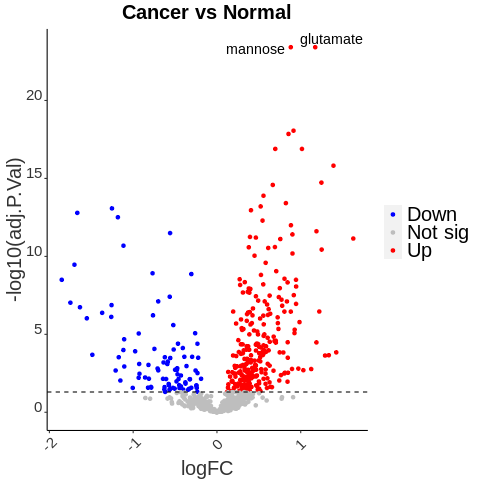

In [82]:
%%R
options(repr.plot.width = 10, repr.plot.height = 6)

my_vlocano_plot(DEGs,'Cancer vs Normal')

Enhanced Volcano

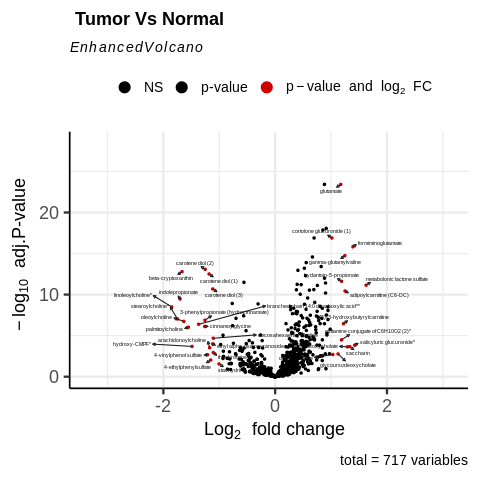

In [123]:
%%R
EnhancedVolcano(DEGs,
                #lab = "glutamate",
                lab = row.names(DEGs),
                x = 'logFC',
                y =  'adj.P.Val',
                title = ' Tumor Vs Normal',
                #selectLab = c('VCAM1','KCTD12','ADAM12'),
                ylab = bquote(~-log[10]~ 'adj.P-value'),
                xlab = bquote(~Log[2]~ 'fold change'),
                boxedLabels = FALSE,
                drawConnectors = TRUE,
                pCutoff = 0.05,
                FCcutoff =1,
                pointSize = 1.0,
                labSize = 1.8,
                colAlpha = 1,
                cutoffLineType = 'blank',
                cutoffLineCol = 'black',
                cutoffLineWidth = 0.8,
                #gridlines.major = FALSE,
                #gridlines.minor = FALSE,
                col = c('black', 'black', 'black', 'red3')
                )

In [136]:
%%R
overlapping=read.csv(file="ORA_results.tab",check.names = T,sep='\t')
overlapping <- overlapping %>% filter(p.value<0.001)
head(overlapping)

       p.value      q.value
1 4.208422e-29 1.392988e-26
2 2.078829e-26 3.440462e-24
3 1.339749e-22 1.478190e-20
4 2.035672e-19 1.684518e-17
5 1.017586e-18 6.736419e-17
6 6.897849e-18 3.805313e-16
                                                              pathway   source
1                                SLC-mediated transmembrane transport Reactome
2                                        Transport of small molecules Reactome
3                                                          Metabolism Reactome
4          Central carbon metabolism in cancer - Homo sapiens (human)     KEGG
5                           Metabolism of amino acids and derivatives Reactome
6 Transport of inorganic cations/anions and amino acids/oligopeptides Reactome
    external_id
1  R-HSA-425407
2  R-HSA-382551
3 R-HSA-1430728
4 path:hsa05230
5   R-HSA-71291
6  R-HSA-425393
                                                                                                                                           

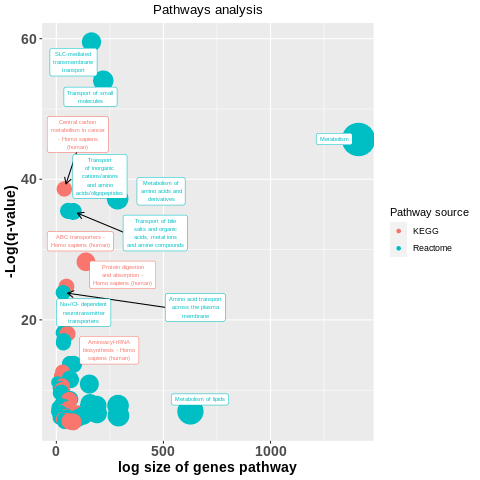

In [135]:
%%R
options(repr.plot.width=8,repr.plot.height=6)

overlapping_filtered <- overlapping
zz=str_wrap(overlapping_filtered$pathway,width = 50)

p6 <- ggplot() +  
  geom_point( data=overlapping_filtered, mapping=aes(x = overlapping_filtered$size,
                                                     y =-log(overlapping_filtered$q.value),
                                                     color=overlapping_filtered$source,
                                                     size=overlapping_filtered$size)) +
  scale_size(range = c(5, 15),guide = 'none')+
  
  labs(x = "log size of genes pathway", y = "-Log(q-value)",color="Pathway source",size="# of overlaped metabolites") +
  ggtitle("Pathways analysis")+
  geom_label_repel(aes(x = overlapping_filtered$size,
                       y =-log(overlapping_filtered$q.value), color=overlapping_filtered$source,
                       label =str_wrap(overlapping_filtered$pathway,width=20)) ,
                   min.segment.length = unit(2, 'lines'),
                   size = 2,force=1, arrow = arrow(length = unit(0.02, "npc")),segment.color = 'black',
                   box.padding = unit(0.35, "lines"),
                   point.padding = unit(0.5, "lines"),show_guide = F) +
  theme(plot.title = element_text(hjust = 0.5),axis.text=element_text(size=14,face="bold"),
        axis.title=element_text(size=14,face="bold"))

print(p6)
